In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

**Don't forget to upvote if you like it ^^ **

In [ ]:
import xgboost as xgb
import lightgbm as lgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Dense, Dropout, SpatialDropout1D, Activation, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.layers import CuDNNLSTM, CuDNNGRU
from keras.utils import np_utils
from sklearn import preprocessing, model_selection, decomposition, metrics, pipeline
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, AveragePooling1D, MaxPooling1D, Flatten, Bidirectional
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

In [ ]:
train = pd.read_csv('../input/spooky-author-identification/train.csv')
test = pd.read_csv('../input/spooky-author-identification/test.csv')
sample = pd.read_csv('../input/spooky-author-identification/sample_submission.csv')

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
sample.head()

In [ ]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [ ]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train.author.values)

In [ ]:
print('Training shape', train.shape)
print('Test shape', test.shape)

**Cross Validation - Train-Test- Split**

In [ ]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.text.values, y,
                                                 stratify = y,
                                                 random_state = 42,
                                                 test_size = 0.1, shuffle = True) 

In [ ]:
print(xtrain.shape)
print(xvalid.shape)

**Building Basic Models**

Let's start building our very first model.

Our very first model is a simple TF-IDF (Term Frequency - Inverse Document Frequency) followed by a simple Logistic Regression.

In [ ]:
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df = 3, max_features = None,
                     strip_accents = 'unicode', analyzer = 'word', token_pattern = r'\w{1,}',
                     ngram_range = (1, 3), use_idf = 1, smooth_idf = 1, sublinear_tf = 1,
                     stop_words = 'english')
# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv = tfv.transform(xtrain)
xvalid_tfv = tfv.transform(xvalid)

In [ ]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression(C = 1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
print('Logloss: %0.3f' % multiclass_logloss(yvalid, predictions))

In [ ]:
ctv = CountVectorizer(analyzer = 'word', token_pattern = r'\w{1,}',
                     ngram_range = (1, 3), stop_words = 'english')
# Fitting Count Vectorizer to both trainning and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv = ctv.transform(xtrain)
xvalid_ctv = ctv.transform(xvalid)

In [ ]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

In [ ]:
# Fitting a simple Naive Bayes on TFIDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)
print ('logloss: %0.3f' % multiclass_logloss(yvalid, predictions))

In [ ]:
# Fitting a simple Naive Bayes on Counts
clf = MultinomialNB()
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

In [ ]:
# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model.
svd = decomposition.TruncatedSVD(n_components = 120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)
# Scale the data obtained from SVD. Remaning variable to reuse without scaling
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)

In [ ]:
# Fitting a simple SVM
clf = SVC(C = 1.0, probability = True) # scine we need probabilities
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict_proba(xvalid_svd_scl)

print('logloss: %0.3f' % multiclass_logloss(yvalid, predictions))

In [ ]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth = 7, n_estimators = 200, colsample_bytree = 0.8,
                       subsample = 0.8, nthread = 10, learning_rate = 0.1)
clf.fit(xtrain_tfv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_tfv.tocsc())
print('logloss: %0.3f' % multiclass_logloss(yvalid, predictions))

In [ ]:
# Fitting a simple xgboost on tf-idf svd features
clf = xgb.XGBClassifier(nthread=10)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

**Grid Search CV**

Its a technique for hyperparameter optimization. Not so effective but can give good results if you know the grid you want to use. I specify the parameters that should usually be used in this post: 

http://blog.kaggle.com/2016/07/21/approaching-almost-any-machine-learning-problem-abhishek-thakur/ 

Please keep in mind that these are the parameters I usually use. There are many other methods of hyperparameter optimization which may or may not be as effective.

In this section, I'll talk about grid search using logistic regression.

Before starting with grid search we need to create a scoring function. This is accomplished using the make_scorer function of scikit-learn.

In [ ]:
mll_scorer = metrics.make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True)

In [ ]:
# Initialize SVD
svd = TruncatedSVD()
    
# Initialize the standard scaler 
scl = preprocessing.StandardScaler()

# We will use logistic regression here..
lr_model = LogisticRegression()

# Create the pipeline 
clf = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', lr_model)])

In [ ]:
param_grid = {'svd__n_components' : [120, 180],
              'lr__C': [0.1, 1.0, 10], 
              'lr__penalty': ['l1', 'l2']}

In [ ]:
# Initialize Grid Search Model
model = GridSearchCV(estimator = clf, param_grid = param_grid, scoring = mll_scorer, 
                    verbose = 10, n_jobs = -1, iid = True, refit = True, cv = 2)
# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain)
print('Best Score: %0.3f' % model.best_score_)
print('Best parameters set:')
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))

In [ ]:
nb_model = MultinomialNB()

# Create the pipeline 
clf = pipeline.Pipeline([('nb', nb_model)])

# parameter grid
param_grid = {'nb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=mll_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain)  # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [ ]:
EMB_PATH = '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype = 'float32')

def load_embedding(embed_dir = EMB_PATH):
    embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in tqdm(open(embed_dir)))
    return embedding_index

def build_embedding_matrix(word_index, embedding_index, max_features, lower = True, verbose = True):
    embedding_matrix = np.zeros((max_features, 300))
    for word, i in tqdm(word_index.items(), disable = not verbose):
        if lower:
            word = word.lower()
        if i >= max_features: continue
        try:
            embedding_vector = embedding_index[word]
        except:
            embedding_vector = embedding_index['unknown']
        if embedding_vector is not None:
            embedding_matrixp[i] = embeeding_vector
    return embedding_matrix

def build_matrix(word_index, embeddings_index):
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except:
            embedding_matrix[i] = embedding_index['unknown']
    return embedding_matrix

In [ ]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('../input/glove840b300dtxt/glove.840B.300d.txt', encoding='utf8')
for line in tqdm(f):
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower().encode().decode('utf-8')
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [ ]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]

In [ ]:
# Fitting a simple xgboost on glove features
xtrain_glove = np.asarray(xtrain_glove)
clf = xgb.XGBClassifier(nthread = 10, silent = False)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)
print('looloss: %0.3f' % multiclass_logloss(yvalid, predictions))

In [ ]:
# Fitting a simple xgboost on glove features
xtrain_glove = np.asarray(xtrain_glove)
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, silent=False)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

** Deep Learning **

But this is an era of deep learning! We cant live without training a few neural networks. Here, we will train LSTM and a simple dense network on the GloVe features. Let's start with the dense network first

In [ ]:
# scale the data before any neural net:
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.fit_transform(xvalid_glove)

In [ ]:
# we need to binarize the labels for the neural net
ytrain_enc = np_utils.to_categorical(ytrain)
yvalid_enc = np_utils.to_categorical(yvalid)

In [ ]:
# create a simple 3 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(3))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

In [ ]:
model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=5, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))

In [ ]:
model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=50, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))

In [ ]:
model = Sequential()
model.add(Dense(300, input_dim = 300, activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(56, activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
          
model.add(Dense(3, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'RMSprop')
model.summary()         

In [ ]:
model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size = 64, 
          epochs=50, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))

**To be continued........**

You need to keep on tuning the parameters of the neural network, add more layers, increase dropout to get better results. Here, I'm just showing that its fast to implement and run and gets better result than xgboost without any optimization :)

To move further, i.e. with LSTMs we need to tokenize the text data

In [ ]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1, 
         300, weights = [embedding_matrix],
         input_length = max_len,
         trainable = False))


model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, verbose=1, 
          validation_data=(xvalid_pad, yvalid_enc))

In [ ]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

In [ ]:
# A simple bidirectional LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size = 512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

In [ ]:
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

In [ ]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Embedding, concatenate, CuDNNGRU, CuDNNLSTM, Bidirectional, GlobalAveragePooling1D 
from keras.layers import GlobalMaxPooling1D, SpatialDropout1D, Flatten, Lambda, Permute, Reshape, merge, Dropout, Conv2D 
from keras.layers import MaxPool2D, Concatenate, Conv1D, MaxPool1D, add, MaxPooling1D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.losses import binary_crossentropy  # thay binary_crossentropy bang categorical_crossentropy

from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.initializers import glorot_uniform, he_uniform, he_normal
from keras.optimizers import Adam
from keras.layers import LeakyReLU, multiply
from keras.layers import Reshape, Permute, multiply

In [ ]:
def build_gru_model(embedding_matrix, name = "gru"):
    
    inp = Input(shape=(max_len, ))
    x = Embedding(len(word_index) + 1, 300 , weights=[embedding_matrix],
                  input_length = max_len,trainable=False)(inp)
    x = SpatialDropout1D(0.4,seed=1234)(x)
    x = CuDNNGRU(128, return_sequences=True,kernel_initializer=glorot_uniform(seed=1234))(x)
    x = CuDNNGRU(64, return_sequences=True,kernel_initializer=glorot_uniform(seed=1234))(x)
    last = Flatten()(Lambda(lambda x: x[:,-1:,:]) (x))
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool, last])
    #x = Dropout(.3,seed=seed_nb)(x)
    x = Dense(32, activation = 'relu')(conc)
    outp = Dense(3, activation="sigmoid")(x)
    
    model = Model(inputs=[inp], outputs=outp, name = name)
    return model

In [ ]:
K.clear_session()
batch_size = 512
model = build_gru_model(embedding_matrix, name = 'gru_stage0')
model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer=Adam())
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs = 50, 
          verbose = True, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

**Attention Layer**

In [ ]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

**Capsule Layer**

In [ ]:
def squash(x, axis=-1):
    # s_squared_norm is really small
    # s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    # scale = K.sqrt(s_squared_norm)/ (0.5 + s_squared_norm)
    # return scale * x
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True)
    scale = K.sqrt(s_squared_norm + K.epsilon())
    return x / scale

# A Capsule Implement with Pure Keras
class Capsule(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, kernel_size=(9, 1), share_weights=True,
                 activation='default', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_size = kernel_size
        self.share_weights = share_weights
        if activation == 'default':
            self.activation = squash
        else:
            self.activation = Activation(activation)

    def build(self, input_shape):
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     # shape=self.kernel_size,
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, u_vecs):
        if self.share_weights:
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])

        batch_size = K.shape(u_vecs)[0]
        input_num_capsule = K.shape(u_vecs)[1]
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule,
                                            self.num_capsule, self.dim_capsule))
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        # final u_hat_vecs.shape = [None, num_capsule, input_num_capsule, dim_capsule]

        b = K.zeros_like(u_hat_vecs[:, :, :, 0])  # shape = [None, num_capsule, input_num_capsule]
        for i in range(self.routings):
            b = K.permute_dimensions(b, (0, 2, 1))  # shape = [None, input_num_capsule, num_capsule]
            c = K.softmax(b)
            c = K.permute_dimensions(c, (0, 2, 1))
            b = K.permute_dimensions(b, (0, 2, 1))
            outputs = self.activation(tf.keras.backend.batch_dot(c, u_hat_vecs, [2, 2]))
            if i < self.routings - 1:
                b = tf.keras.backend.batch_dot(outputs, u_hat_vecs, [2, 3])

        return outputs

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

In [ ]:
def build_gru_lstm_model(embedding_matrix, name = ""):
    
    inp = Input(shape=(max_len, ))
    x = Embedding(len(word_index) + 1, 300 , weights=[embedding_matrix],
                  input_length = max_len,trainable=False)(inp)
    x = SpatialDropout1D(0.3, seed = 123)(x)
    x = Bidirectional(CuDNNGRU(128, return_sequences=True,kernel_initializer=glorot_uniform(seed= 123)))(x)
    x = Dropout(0.2, seed = 123)(x)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True,kernel_initializer=glorot_uniform(seed=123)))(x)

    last = Flatten()(Lambda(lambda x: x[:,-1:,:]) (x))
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool,max_pool,last])
    x = Dropout(0.3, seed = 123)(x)
    outp = Dense(3, activation="sigmoid",kernel_initializer=he_uniform(seed = 123))(conc)
    
    model = Model(inputs=[inp], outputs=outp, name = name)
    return model

In [ ]:
K.clear_session()
batch_size = 512
model = build_gru_lstm_model(embedding_matrix, name = 'gru_lstm_model')
model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer=Adam())
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs = 50, 
          verbose = True, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

**Ensemble Modeling**

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
import pandas as pd
import os
import sys
import logging

logging.basicConfig(
    level=logging.DEBUG,
    format="[%(asctime)s] %(levelname)s %(message)s",
    datefmt="%H:%M:%S", stream=sys.stdout)
logger = logging.getLogger(__name__)


class Ensembler(object):
    def __init__(self, model_dict, num_folds=3, task_type='classification', optimize=roc_auc_score,
                 lower_is_better=False, save_path=None):
        """
        Ensembler init function
        :param model_dict: model dictionary, see README for its format
        :param num_folds: the number of folds for ensembling
        :param task_type: classification or regression
        :param optimize: the function to optimize for, e.g. AUC, logloss, etc. Must have two arguments y_test and y_pred
        :param lower_is_better: is lower value of optimization function better or higher
        :param save_path: path to which model pickles will be dumped to along with generated predictions, or None
        """

        self.model_dict = model_dict
        self.levels = len(self.model_dict)
        self.num_folds = num_folds
        self.task_type = task_type
        self.optimize = optimize
        self.lower_is_better = lower_is_better
        self.save_path = save_path

        self.training_data = None
        self.test_data = None
        self.y = None
        self.lbl_enc = None
        self.y_enc = None
        self.train_prediction_dict = None
        self.test_prediction_dict = None
        self.num_classes = None

    def fit(self, training_data, y, lentrain):
        """
        :param training_data: training data in tabular format
        :param y: binary, multi-class or regression
        :return: chain of models to be used in prediction
        """

        self.training_data = training_data
        self.y = y

        if self.task_type == 'classification':
            self.num_classes = len(np.unique(self.y))
            logger.info("Found %d classes", self.num_classes)
            self.lbl_enc = LabelEncoder()
            self.y_enc = self.lbl_enc.fit_transform(self.y)
            kf = StratifiedKFold(n_splits=self.num_folds)
            train_prediction_shape = (lentrain, self.num_classes)
        else:
            self.num_classes = -1
            self.y_enc = self.y
            kf = KFold(n_splits=self.num_folds)
            train_prediction_shape = (lentrain, 1)

        self.train_prediction_dict = {}
        for level in range(self.levels):
            self.train_prediction_dict[level] = np.zeros((train_prediction_shape[0],
                                                          train_prediction_shape[1] * len(self.model_dict[level])))

        for level in range(self.levels):

            if level == 0:
                temp_train = self.training_data
            else:
                temp_train = self.train_prediction_dict[level - 1]

            for model_num, model in enumerate(self.model_dict[level]):
                validation_scores = []
                foldnum = 1
                for train_index, valid_index in kf.split(self.train_prediction_dict[0], self.y_enc):
                    logger.info("Training Level %d Fold # %d. Model # %d", level, foldnum, model_num)

                    if level != 0:
                        l_training_data = temp_train[train_index]
                        l_validation_data = temp_train[valid_index]
                        model.fit(l_training_data, self.y_enc[train_index])
                    else:
                        l0_training_data = temp_train[0][model_num]
                        if type(l0_training_data) == list:
                            l_training_data = [x[train_index] for x in l0_training_data]
                            l_validation_data = [x[valid_index] for x in l0_training_data]
                        else:
                            l_training_data = l0_training_data[train_index]
                            l_validation_data = l0_training_data[valid_index]
                        model.fit(l_training_data, self.y_enc[train_index])

                    logger.info("Predicting Level %d. Fold # %d. Model # %d", level, foldnum, model_num)

                    if self.task_type == 'classification':
                        temp_train_predictions = model.predict_proba(l_validation_data)
                        self.train_prediction_dict[level][valid_index,
                        (model_num * self.num_classes):(model_num * self.num_classes) +
                                                       self.num_classes] = temp_train_predictions

                    else:
                        temp_train_predictions = model.predict(l_validation_data)
                        self.train_prediction_dict[level][valid_index, model_num] = temp_train_predictions
                    validation_score = self.optimize(self.y_enc[valid_index], temp_train_predictions)
                    validation_scores.append(validation_score)
                    logger.info("Level %d. Fold # %d. Model # %d. Validation Score = %f", level, foldnum, model_num,
                                validation_score)
                    foldnum += 1
                avg_score = np.mean(validation_scores)
                std_score = np.std(validation_scores)
                logger.info("Level %d. Model # %d. Mean Score = %f. Std Dev = %f", level, model_num,
                            avg_score, std_score)

            logger.info("Saving predictions for level # %d", level)
            train_predictions_df = pd.DataFrame(self.train_prediction_dict[level])
            train_predictions_df.to_csv(os.path.join(self.save_path, "train_predictions_level_" + str(level) + ".csv"),
                                        index=False, header=None)

        return self.train_prediction_dict

    def predict(self, test_data, lentest):
        self.test_data = test_data
        if self.task_type == 'classification':
            test_prediction_shape = (lentest, self.num_classes)
        else:
            test_prediction_shape = (lentest, 1)

        self.test_prediction_dict = {}
        for level in range(self.levels):
            self.test_prediction_dict[level] = np.zeros((test_prediction_shape[0],
                                                         test_prediction_shape[1] * len(self.model_dict[level])))
        self.test_data = test_data
        for level in range(self.levels):
            if level == 0:
                temp_train = self.training_data
                temp_test = self.test_data
            else:
                temp_train = self.train_prediction_dict[level - 1]
                temp_test = self.test_prediction_dict[level - 1]

            for model_num, model in enumerate(self.model_dict[level]):

                logger.info("Training Fulldata Level %d. Model # %d", level, model_num)
                if level == 0:
                    model.fit(temp_train[0][model_num], self.y_enc)
                else:
                    model.fit(temp_train, self.y_enc)

                logger.info("Predicting Test Level %d. Model # %d", level, model_num)

                if self.task_type == 'classification':
                    if level == 0:
                        temp_test_predictions = model.predict_proba(temp_test[0][model_num])
                    else:
                        temp_test_predictions = model.predict_proba(temp_test)
                    self.test_prediction_dict[level][:, (model_num * self.num_classes): (model_num * self.num_classes) +
                                                                                        self.num_classes] = temp_test_predictions

                else:
                    if level == 0:
                        temp_test_predictions = model.predict(temp_test[0][model_num])
                    else:
                        temp_test_predictions = model.predict(temp_test)
                    self.test_prediction_dict[level][:, model_num] = temp_test_predictions

            test_predictions_df = pd.DataFrame(self.test_prediction_dict[level])
            test_predictions_df.to_csv(os.path.join(self.save_path, "test_predictions_level_" + str(level) + ".csv"),
                                       index=False, header=None)

        return self.test_prediction_dict

In [ ]:
# specify the data to be used for every level of ensembling:
xtrain_glove = np.asarray(xtrain_glove)
xvalid_glove = np.asarray(xvalid_glove)
train_data_dict = {0: [xtrain_tfv, xtrain_ctv, xtrain_tfv, xtrain_ctv], 1: [xtrain_glove]}
test_data_dict = {0: [xvalid_tfv, xvalid_ctv, xvalid_tfv, xvalid_ctv], 1: [xvalid_glove]}

model_dict = {0: [LogisticRegression(), LogisticRegression(), MultinomialNB(alpha=0.1), MultinomialNB()],

              1: [xgb.XGBClassifier(silent=True, n_estimators=120, max_depth=7)]}

ens = Ensembler(model_dict=model_dict, num_folds=3, task_type='classification',
                optimize=multiclass_logloss, lower_is_better=True, save_path='')

ens.fit(train_data_dict, ytrain, lentrain=xtrain_glove.shape[0])
preds = ens.predict(test_data_dict, lentest=xvalid_glove.shape[0])

In [ ]:
multiclass_logloss(yvalid, preds[1])

**Topic Modeling**

1. Latent Dirichlet Allocation - Probabilistic, generative model which uncovers the topics latent to a dataset by assigning weights to words in a corpus, where each topic will assign different probability weights to each word.

2. Non-negative Matrix Factorization - Approximation method that takes an input matrix and approximates the factorization of this matrix into two other matrices, with the caveat that the values in the matrix be non-negative.

In [ ]:
import base64
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter
from scipy.misc import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk

In [ ]:
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}
data = [go.Bar(
            x = train.author.map(z).unique(),
            y = train.author.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = train.author.value_counts().values
                        ),
            text='Text entries attributed to Author'
    )]

layout = go.Layout(
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [ ]:
all_words = train['text'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [ ]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

This is now the perfect opportunity to piece together all the text preprocessing steps that was mentioned in the previous section. So you're asking yourself, do we really need to go through all the effort and steps again in defining tokenization, stopword removals, stemming/lemmatizing etc?

Thankfully we do not need to go through all of that again. I conveniently omitted a key detail about Sklearn vectorizers but will mention it at this juncture. When you vectorize the raw text with CountVectorizer, the dual stages of tokenizing and stopwords filtering are automatically included as a high-level component. Here unlike the NLTK tokenizer that you were introduced to in the Section 2a earlier, Sklearn's tokenizer discards all single character terms like ('a', 'w' etc) and also lower cases all terms by default. Filtering out stopwords in Sklearn is as convenient as passing the value 'english' into the argument "stop_words" where a built-in English stopword list is automatically used.

Unfortunately, there is no built-in lemmatizer in the vectorizer so we are left with a couple of options. Either implementing it separately everytime before feeding the data for vectorizing or somehow extend the sklearn implementation to include this functionality. Luckily for us, we have the latter option where we can extend the CountVectorizer class by overwriting the "build_analyzer" method as follows:

In [ ]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

In [ ]:
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [ ]:
# Storing the entire training text in a list
text = list(train.text.values)
# Calling our overwritten Count vectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

**Revisiting our Term frequencies**

Having implemented our lemmatized count vectorizer, let us revist the plots for the term frquencies of the top 50 words (by frequency). As you can see from the plot, all our prior preprocessing efforts have not gone to waste. With the removal of stopwords, the remaining words seem much more meaningful where you can see that all the stopwords in the earlier term frequency plot

In [ ]:
feature_names = tf_vectorizer.get_feature_names()
count_vec = np.asarray(tf.sum(axis=0)).ravel()
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))
# Now I want to extract out on the top 15 and bottom 15 words
Y = np.concatenate([y[0:15], y[-16:-1]])
X = np.concatenate([x[0:15], x[-16:-1]])

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[0:50],
            y = y[0:50],
            marker= dict(colorscale='Jet',
                         color = y[0:50]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

# Plotting the Plot.ly plot for the Top 50 word frequencies
data = [go.Bar(
            x = x[-100:],
            y = y[-100:],
            marker= dict(colorscale='Portland',
                         color = y[-100:]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Bottom 100 Word frequencies after Preprocessing'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

**Latent Dirichlet Allocation**

Finally we arrive on the subject of topic modelling and the implementation of a couple of unsupervised learning algorithms. The first method that I will touch upon is Latent Dirichlet Allocation. Now there are a couple of different implements of this LDA algorithm but in this notebook, I will be using Sklearn's implementation. Another very well-known LDA implementation is Radim Rehurek's gensim, so check it out as well.

C**orpus - Document - Word : Topic Generation**

In LDA, the modelling process revolves around three things: the text corpus, its collection of documents, D and the words W in the documents. Therefore the algorithm attempts to uncover K topics from this corpus via the following way (illustrated by the diagram)

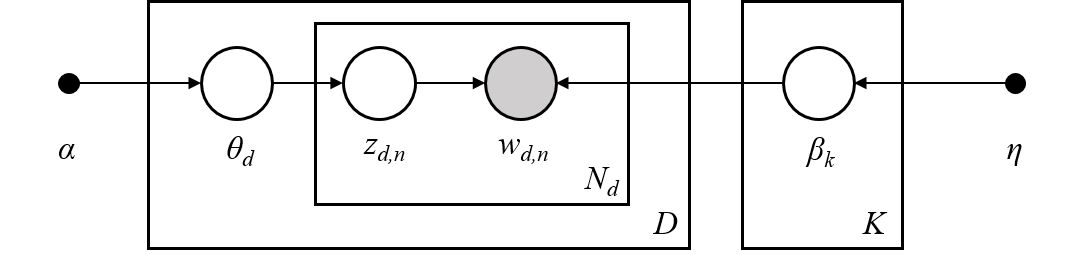

Model each topic,  κ  via a Dirichlet prior distribution given by  βk :



Model each document d by another Dirichlet distribution parameterized by  α :



Subsequently for document d, we generate a topic via a multinomial distribution which we then backtrack and use to generate the correspondings words related to that topic via another multinomial distribution:



(Image source: http://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation)

The LDA algorithm first models documents via a mixture model of topics. From these topics, words are then assigned weights based on the probability distribution of these topics. It is this probabilistic assignment over words that allow a user of LDA to say how likely a particular word falls into a topic. Subsequently from the collection of words assigned to a particular topic, are we thus able to gain an insight as to what that topic may actually represent from a lexical point of view.

From a standard LDA model, there are really a few key parameters that we have to keep in mind and consider programmatically tuning before we invoke the model:

1. n_components: The number of topics that you specify to the model
2. α  parameter: This is the dirichlet parameter that can be linked to the document topic prior
3. β  parameter: This is the dirichlet parameter linked to the topic word prior

To invoke the algorithm, we simply create an LDA instance through the Sklearn's LatentDirichletAllocation function. The various parameters would ideally have been obtained through some sort of validation scheme. In this instance, the optimal value of n_components (or topic number) was found by conducting a KMeans + Latent Semantic Analysis Scheme (as shown in this paper here) whereby the number of Kmeans clusters and number of LSA dimensions were iterated through and the best silhouette mean score.

In [ ]:
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [ ]:
lda.fit(tf)

**Topics generated by LDA**

We will utilise our helper function we defined earlier "print_top_words" to return the top 10 words attributed to each of the LDA generated topics. To select the number of topics, this is handled through the parameter n_components in the function.

In [ ]:
n_top_words = 40
print("\nTopics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

In [ ]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]
fourth_topic = lda.components_[3]

In [ ]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

In [ ]:
# Word Cloud of first topic
# Generating the wordcloud with the values under the category dataframe
firstcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

In [ ]:
# Generating the wordcloud with the values under the category dataframe
cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(second_topic_words))
plt.imshow(cloud)
plt.axis('off')
plt.show()

**To be continued........^_^**

**Reference:**

https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial